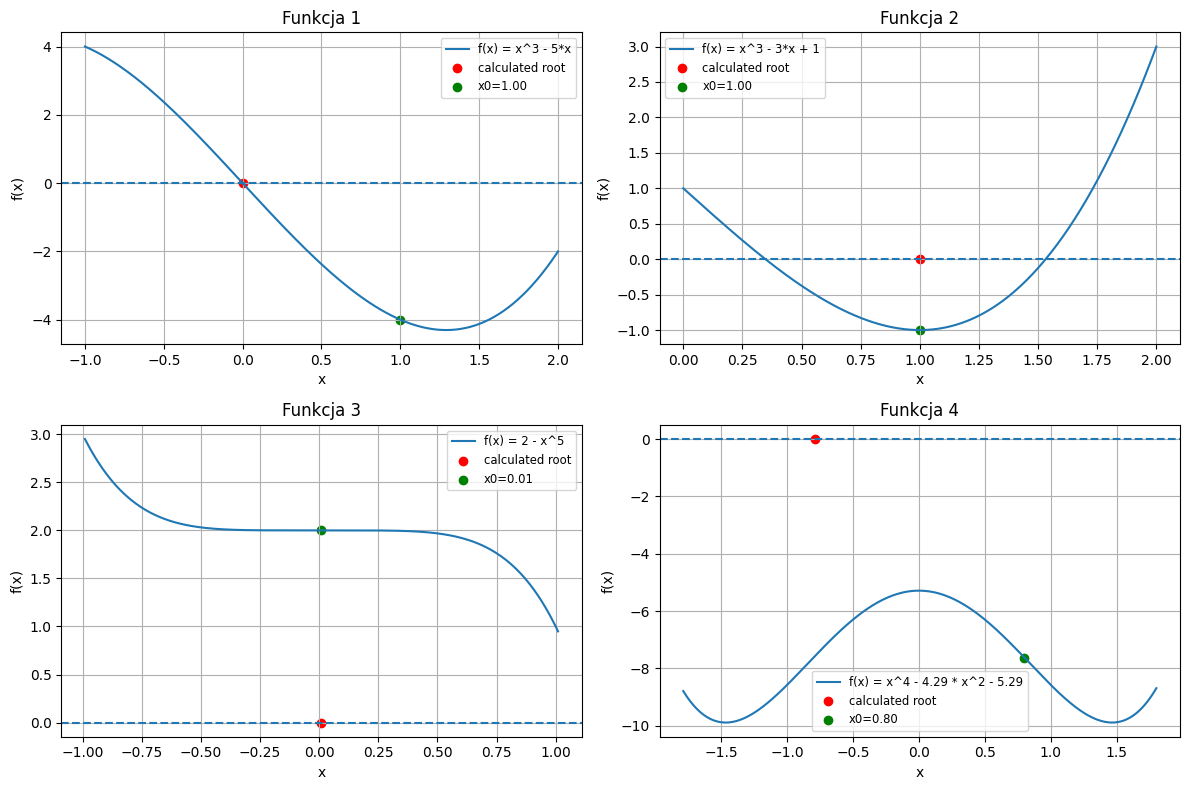

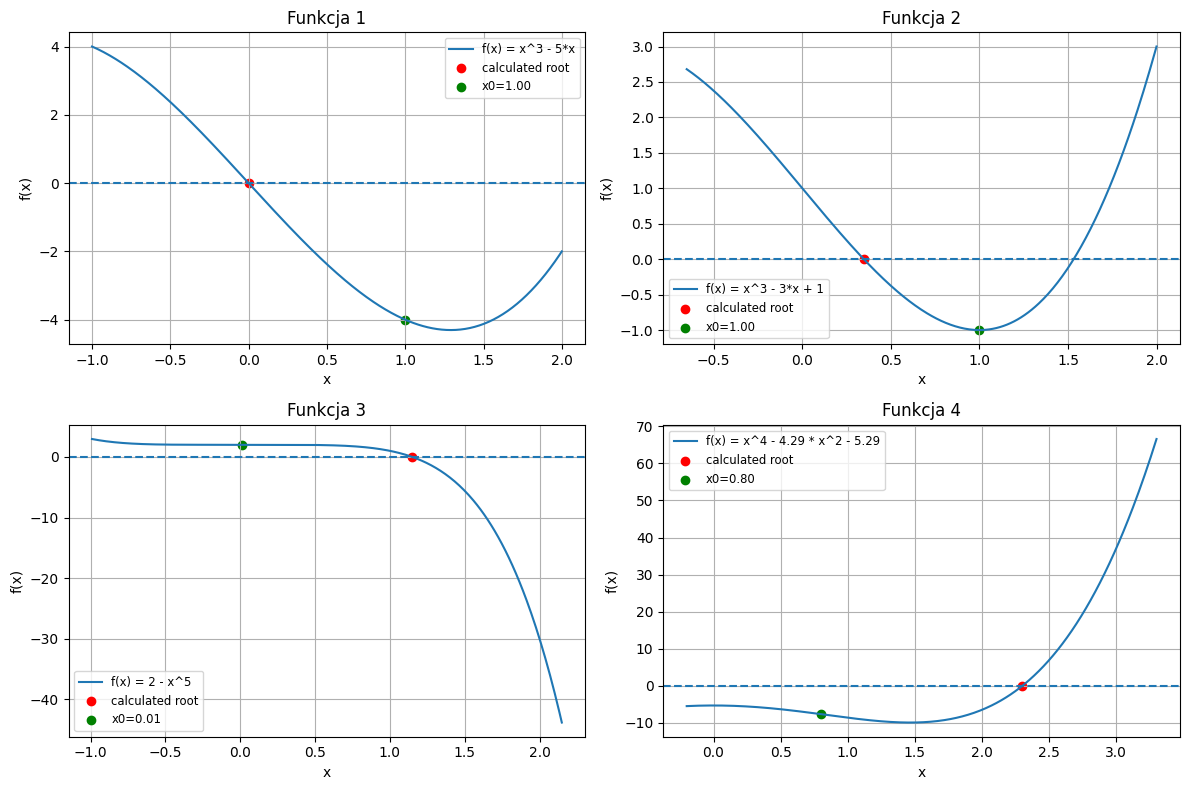

In [10]:
# task 1

from scipy.optimize import newton, bisect
import matplotlib.pyplot as plt
import numpy as np

def plot_roots(data, roots):
    """
    Rysuje wszystkie wykresy funkcji w gridzie 2x2
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for ax, (f, x0, f_desc), root in zip(axes, data, roots):
        # obliczamy jaki zakres mamy objąć
        x_min = min(x0, root) - 1
        x_max = max(x0, root) + 1
        x = np.linspace(x_min, x_max, 400)
        y = f(x)
        
        ax.plot(x, y, label='f(x) = '+f_desc)
        ax.axhline(0, linestyle='--')
        ax.scatter([root], [0], marker='o', label=f'calculated root', color = 'red')
        ax.scatter([x0], [f(x0)], marker='o', label=f'x0={x0:.2f}', color = 'green')

        ax.set_title(f'Funkcja {data.index((f, x0, f_desc))+1}')
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.grid(True)
        ax.legend(loc='best', fontsize='small')
    
    plt.tight_layout()
    plt.show()

f_a = lambda x: x**3 - 5*x 
f_b = lambda x: x**3 - 3*x + 1
f_c = lambda x: 2 - x**5
f_d = lambda x: x**4 - 4.29 * x**2 - 5.29

data = [(f_a, 1, "x^3 - 5*x"), (f_b, 1, "x^3 - 3*x + 1"), (f_c, 0.01, "2 - x^5"), (f_d, 0.8, "x^4 - 4.29 * x^2 - 5.29")] # zbieramy funkcje i x0 razem
newton_roots = [newton(f, x0) for f, x0, _ in data]
# dla każdej funkcji dajemy przykładowe przedziały początkowe
bisect_roots = [bisect(f_a, -1, 1), bisect(f_b, -1, 1),
                 bisect(f_c, 0, 2), bisect(f_d, 2, 3)]

plot_roots(data, newton_roots)
plot_roots(data, bisect_roots)



Schemat phi1:
                                                                           x_k                                                                   epsilon_k      r_exp
k                                                                                                                                                                    
1                                                                   3.66666667                                                                  1.66666667        NaN
2                                                                   5.14814815                                                                  3.14814815        NaN
3                                                                   9.50114312                                                                  7.50114312 1.36518297
4                                                                  30.75724019                                                                 28.75724019 

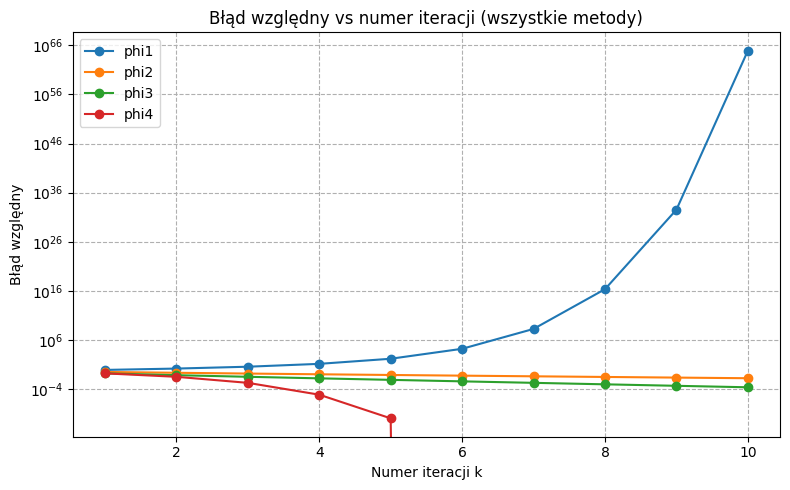

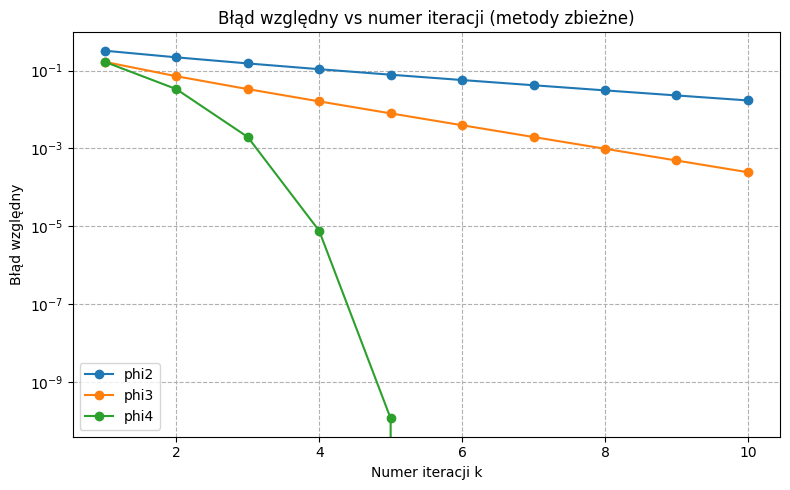

In [ ]:
# task 2

import numpy as np
import pandas as pd

def phi1(x): return (x**2 + 2) / 3
def phi2(x): return np.sqrt(3*x - 2)
def phi3(x): return 3 - 2/x
def phi4(x): return (x**2 - 2) / (2*x - 3)

phi_funcs = {
    "phi1": phi1,
    "phi2": phi2,
    "phi3": phi3,
    "phi4": phi4
}

alpha = 2.0      # rzeczywisty pierwiastek
x0 = 3.0          # punkt startowy
n_iter = 10       # liczba iteracji

for name, phi in phi_funcs.items():
    xs = [x0]
    eps = []
    # wykonanie iteracji
    for _ in range(n_iter):
        x_new = phi(xs[-1])
        xs.append(x_new)
        eps.append(abs(x_new - alpha))
    
    # obliczenie eksperymentalnego rzędu zbieżności
    r = [np.nan, np.nan]  # brak dla k=1,2 (potrzebne przynajmniej 3 wartości do wzoru)
    for k in range(2, len(eps)):
        try:
            num = np.log(eps[k-1] / eps[k])
            den = np.log(eps[k-2] / eps[k-1])
            r.append(num / den)
        except (ZeroDivisionError, FloatingPointError):
            r.append(np.nan)
    
    # przygotowanie tabeli
    df = pd.DataFrame({
        "k": np.arange(1, n_iter+1),
        "x_k": xs[1:],
        "epsilon_k": eps,
        "r_exp": r
    }).set_index("k")
    
    print(f"\nSchemat {name}:")
    print(df.to_string(float_format='%.8f'))

# zbieranie błędów względnych
rel_errors = {}
for name, phi in phi_funcs.items():
    x = x0
    errors = []
    for k in range(n_iter):
        x = phi(x)
        errors.append(abs(x - alpha) / abs(alpha))
    rel_errors[name] = errors

# c) - wspólny wykres wszystkich metod
plt.figure(figsize=(8, 5))
for name, errors in rel_errors.items():
    plt.semilogy(range(1, n_iter+1), errors, marker='o', label=name)
plt.title("Błąd względny vs numer iteracji (wszystkie metody)")
plt.xlabel("Numer iteracji k")
plt.ylabel("Błąd względny")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

# c) - wykres tylko metod zbieżnych (phi2, phi3, phi4)
plt.figure(figsize=(8, 5))
for name in ["phi2", "phi3", "phi4"]:
    plt.semilogy(range(1, n_iter+1), rel_errors[name], marker='o', label=name)
plt.title("Błąd względny vs numer iteracji (metody zbieżne)")
plt.xlabel("Numer iteracji k")
plt.ylabel("Błąd względny")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()